In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import fftpack
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (22, 6)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'fftpack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [343]:
df = pd.read_csv('Data/BMS/Rooms and HVAC/RCU middenhal.csv', delimiter=';', encoding='utf-8')

In [344]:
df_data = df[['Tijdstip', 'Gemiddelde ruimtetemp [°C] - RCU Middelhal 255 ()', 'Luchtkwaliteitopnemer [ppm] - RCU Middelhal 255 (255QT01)']]
df_data.is_copy = False
df_data.columns = ['Time', 'Temperature', 'CO2']

In [345]:
df_data.is_copy = False
df_data['Time'] = pd.to_datetime(df_data['Time'], format="%d-%m-%Y %H:%M.%S")

df_data['Temperature'] = [str(x).replace(',', '.') for x in df_data['Temperature']]
df_data['Temperature'] = pd.to_numeric(df_data['Temperature'], errors='coerce')
df_data['CO2'] = pd.to_numeric(df_data['CO2'], errors='coerce')

In [346]:
df_temp.sort_values(['Time'], inplace=True)

In [347]:
df_data = df_data.loc[df_data['Time'] > datetime.datetime(2017, 10, 23, 9, 0, 0)]
df_data = df_data.loc[df_data['Time'] <= datetime.datetime(2018, 2, 28, 13, 56, 0)]

In [348]:
mean = df_data['Temperature'].mean()
df_data['Temperature_normalized'] = [(i-mean)/mean for i in list(df_data['Temperature'])]

mean = df_data['CO2'].mean()
df_data['CO2_normalized'] = [(i-mean)/mean for i in list(df_data['CO2'])]

In [349]:
def shift(row, mean):

    return (row - mean)

def multi_resolution(df, column1, column2, freq):

    grouped =  df.groupby(pd.Grouper(key='Time', freq=freq))
    norm_df = pd.DataFrame()
    
    mean_temp_list = []
    mean_CO2_list = []
    
    for name, group in grouped:
        df_sub = pd.DataFrame(group)
        
        mean_temp = df_sub[column1].mean()
        mean_temp_list.append(mean_temp)
        df_sub['Temperature_piecewise'] = mean_temp
        
        mean_CO2 = df_sub[column2].mean()
        mean_CO2_list.append(mean_CO2)
        df_sub['CO2_piecewise'] = mean_CO2
        
        df_sub['Temperature_shifted'] = df_sub.apply(lambda row: shift(row[column1], mean_temp), axis=1)
        df_sub['CO2_shifted'] = df_sub.apply(lambda row: shift(row[column2], mean_CO2), axis=1)
        
        norm_df = norm_df.append(df_sub)
    
    return norm_df, mean_temp_list, mean_CO2_list

In [350]:
df_data, mean_temp_week, mean_CO2_week = multi_resolution(df_data, 'Temperature_normalized', \
                                                        'CO2_normalized', 'W')

In [351]:
df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_week', 'CO2_piecewise_week', 'Temperature_shifted_week', 'CO2_shifted_week']

In [352]:
df_data, mean_temp_day, mean_CO2_day = multi_resolution(df_data, 'Temperature_shifted_week', \
                                                      'CO2_shifted_week', 'D')

In [353]:
df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_week', 'CO2_piecewise_week', 'Temperature_shifted_week', 'CO2_shifted_week', \
                  'Temperature_piecewise_day', 'CO2_piecewise_day', 'Temperature_shifted_day', 'CO2_shifted_day']

In [354]:
df_data, mean_temp_2H, mean_CO2_2H = multi_resolution(df_data, 'Temperature_shifted_day', \
                                                      'CO2_shifted_day', '2H')

In [355]:
df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_week', 'CO2_piecewise_week', 'Temperature_shifted_week', 'CO2_shifted_week', \
                  'Temperature_piecewise_day', 'CO2_piecewise_day', 'Temperature_shifted_day', 'CO2_shifted_day', \
                  'Temperature_piecewise_2H', 'CO2_piecewise_2H', 'Temperature_shifted_2H', 'CO2_shifted_2H']

In [356]:
df_data, mean_temp_32Min, mean_CO2_32Min = multi_resolution(df_data, 'Temperature_shifted_2H', \
                                                      'CO2_shifted_2H', '32Min')

In [357]:
df_data.columns = ['Time', 'Temperature', 'CO2', 'Temperature_normalized', 'CO2_normalized', \
                  'Temperature_piecewise_week', 'CO2_piecewise_week', 'Temperature_shifted_week', 'CO2_shifted_week', \
                  'Temperature_piecewise_day', 'CO2_piecewise_day', 'Temperature_shifted_day', 'CO2_shifted_day', \
                  'Temperature_piecewise_2H', 'CO2_piecewise_2H', 'Temperature_shifted_2H', 'CO2_shifted_2H', \
                  'Temperature_piecewise_32Min', 'CO2_piecewise_32Min', 'Temperature_shifted_32Min', 'CO2_shifted_32Min']

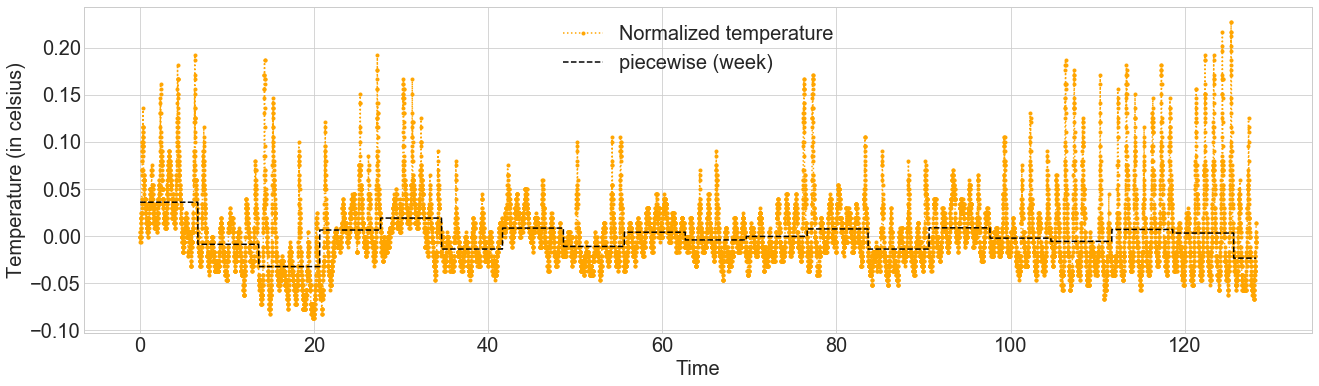

In [362]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_week'], linestyle='--', color="black", label = "piecewise (week)")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

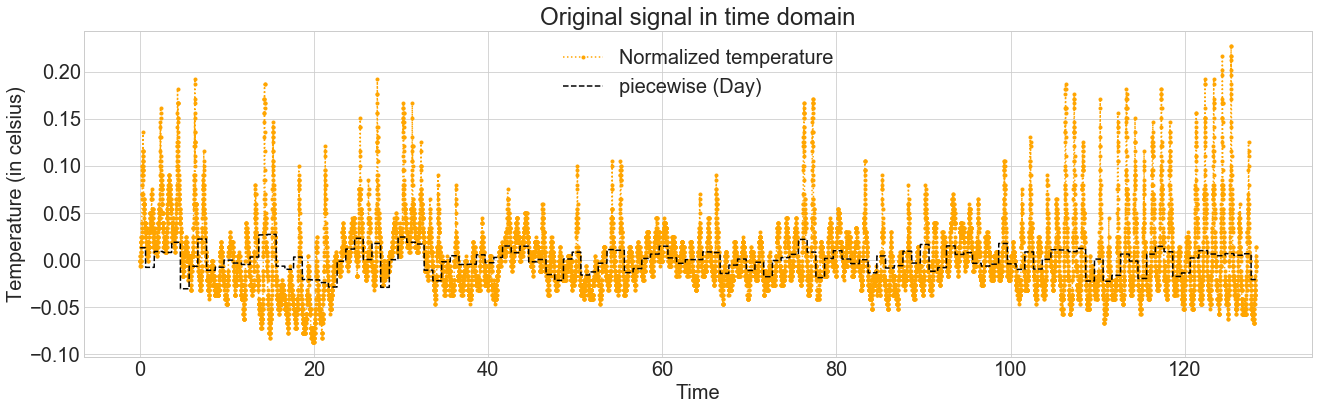

In [363]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_day'], linestyle='--', color="black", label = "piecewise (Day)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

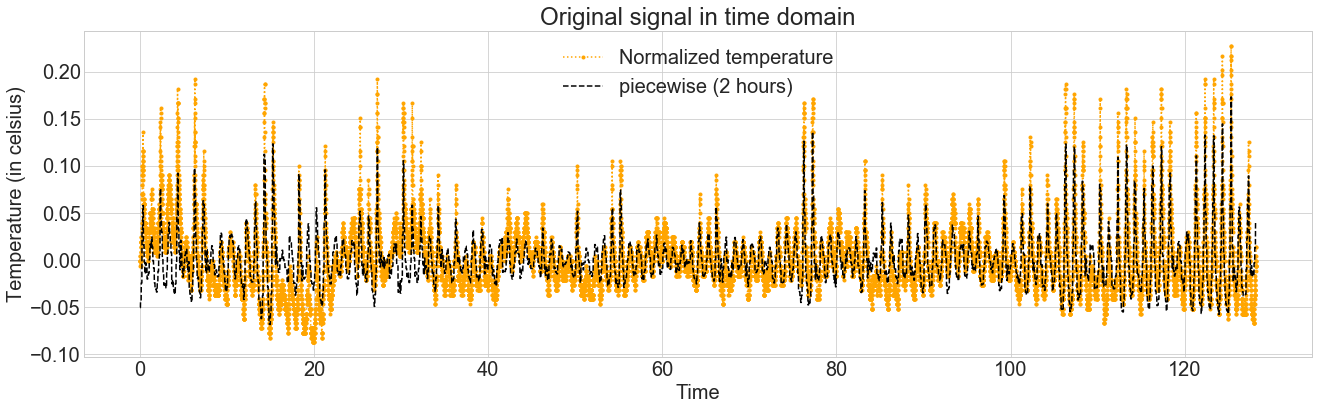

In [364]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_2H'], linestyle='--', color="black", label = "piecewise (2 hours)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

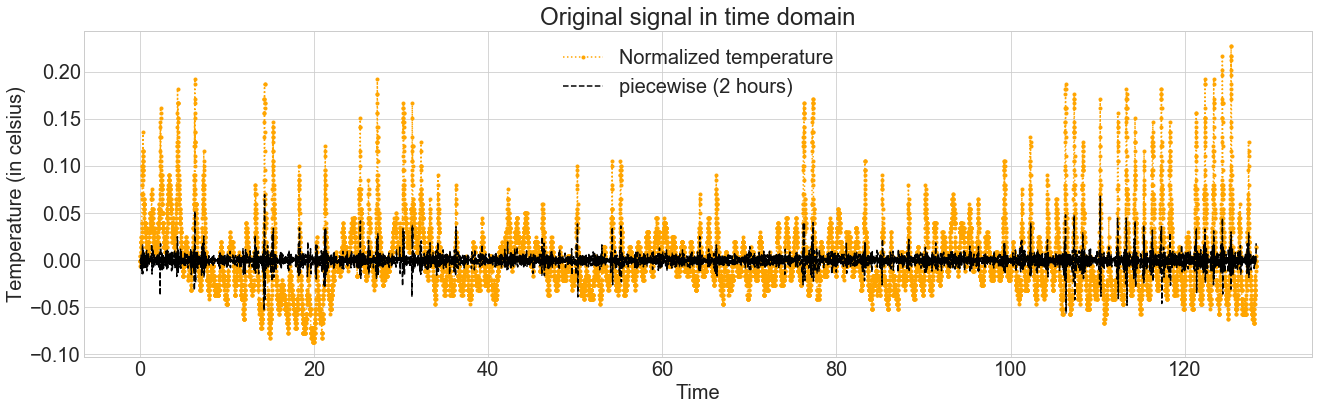

In [361]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_normalized'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
plt.plot(x_range, df_data['Temperature_piecewise_32Min'], linestyle='--', color="black", label = "piecewise (32 Min)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

In [365]:
def autocorr(x):
    result = numpy.correlate(x, x, mode='full')
    return result[int(result.size/2):]

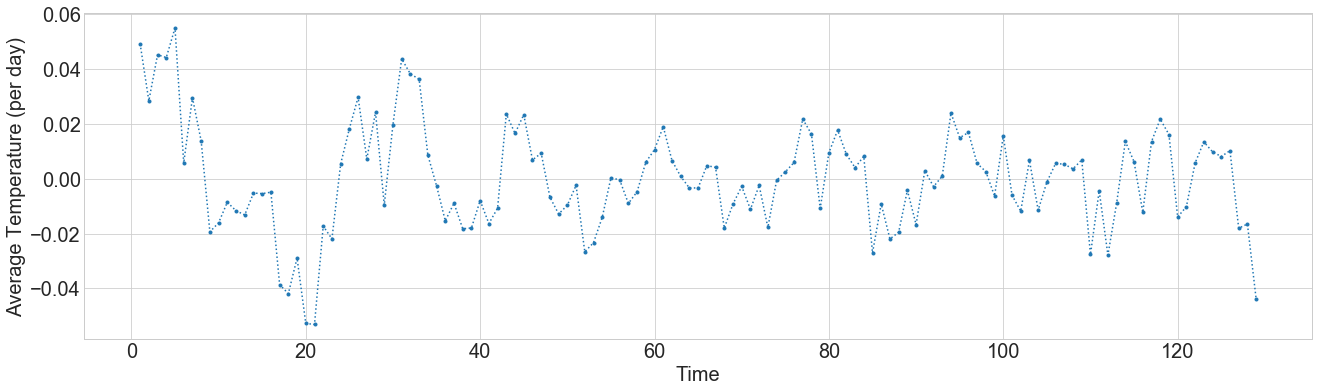

In [182]:
plt.plot(range(1, len(mean_temp_day)+1), mean_temp_day, linestyle=':', marker='.')
# plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Average Temperature (per day)')
plt.show()

<Container object of 3 artists>

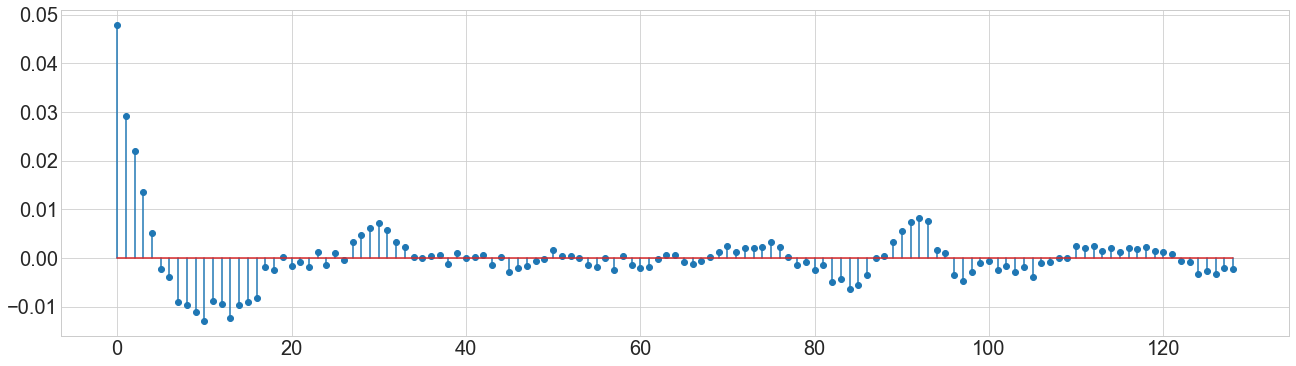

In [183]:
plt.stem(autocorr(mean_temp_day))

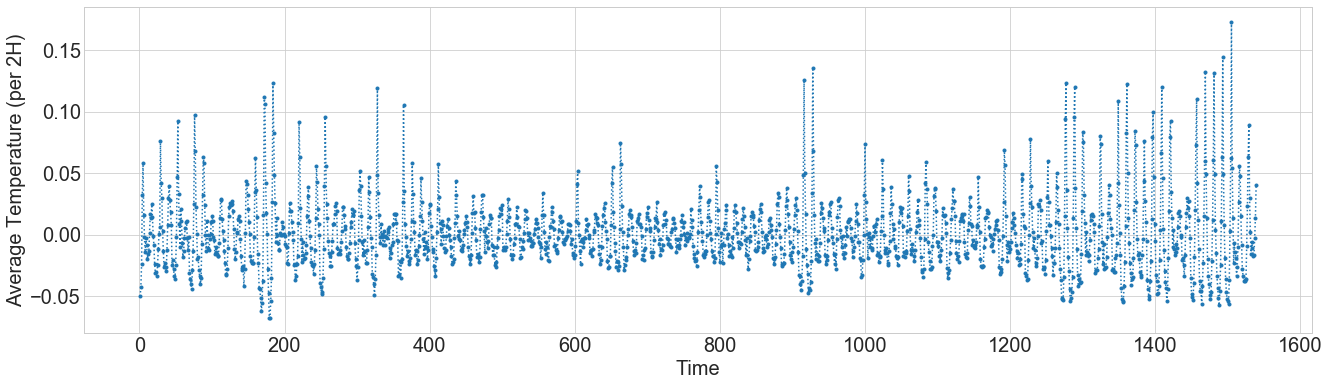

In [184]:
plt.plot(range(1, len(mean_temp_2H)+1), mean_temp_2H, linestyle=':', marker='.')
# plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Average Temperature (per 2H)')
plt.show()

<Container object of 3 artists>

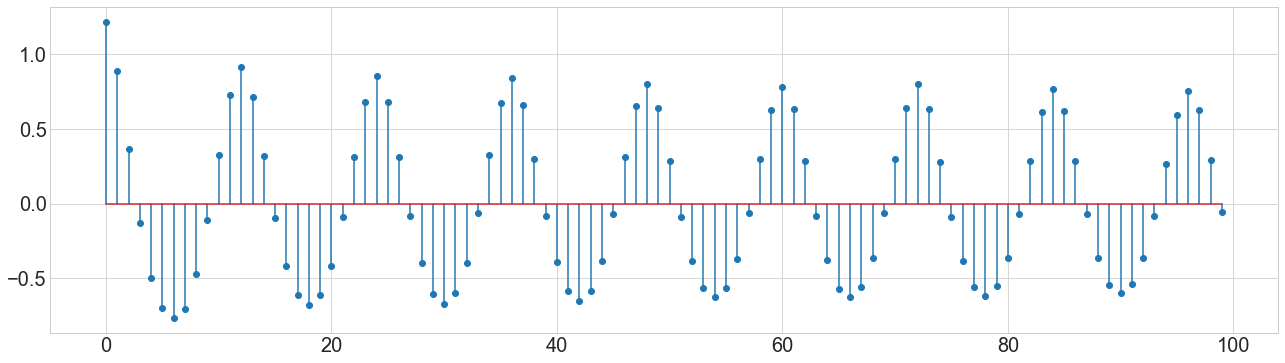

In [185]:
plt.stem(autocorr(mean_temp_2H)[:100])

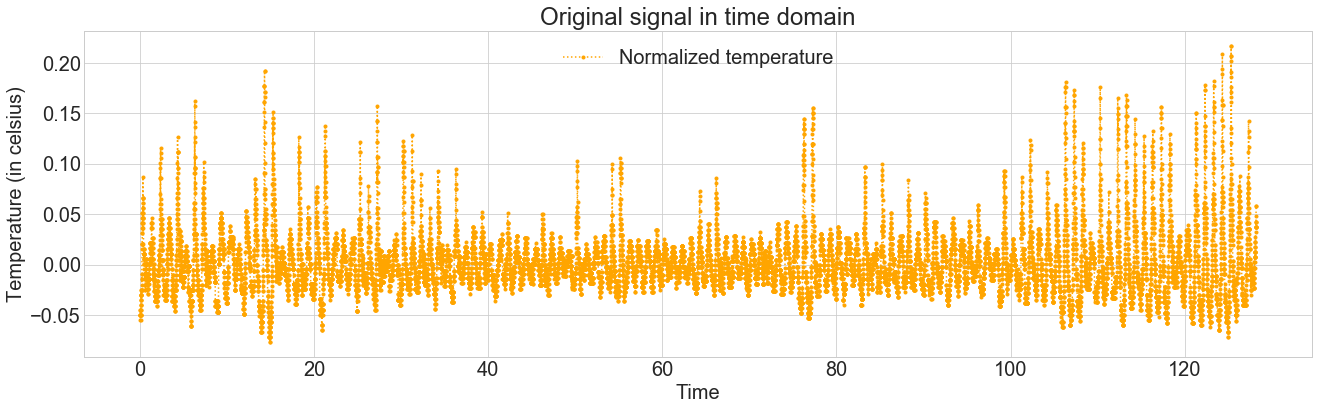

In [250]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_shifted_day'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
# plt.plot(x_range, df_data['Temperature_piecewise_day'], linestyle='--', color="black", label = "piecewise (day)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

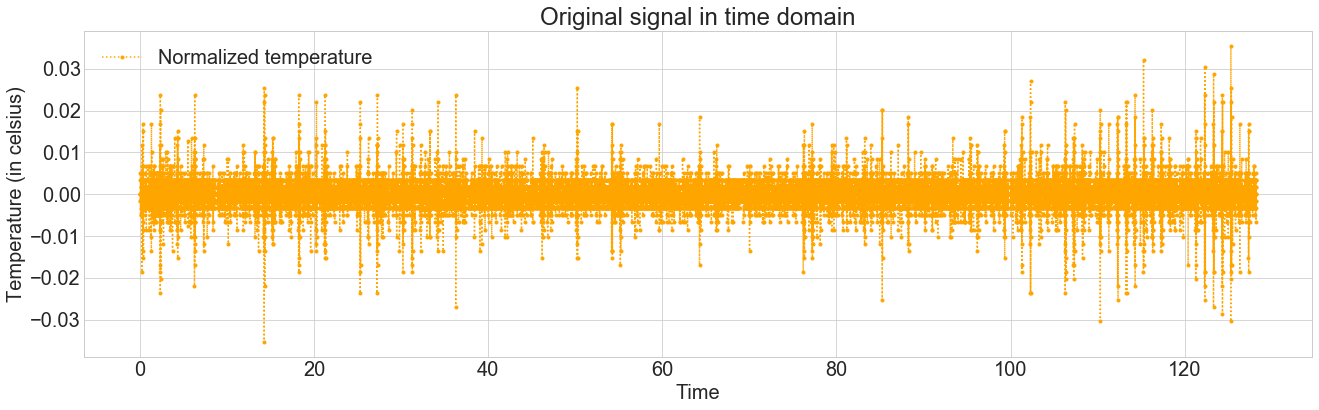

In [340]:
x_range =[(m*480)/(60*60*24) for m in range(1, len(df_data['Temperature_normalized'])+1)]
plt.plot(x_range, df_data['Temperature_shifted_week'], linestyle=':', marker='.', color="orange", label="Normalized temperature")
# plt.plot(x_range, df_data['Temperature_piecewise_day'], linestyle='--', color="black", label = "piecewise (day)")
plt.legend()
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celsius)')
plt.show()

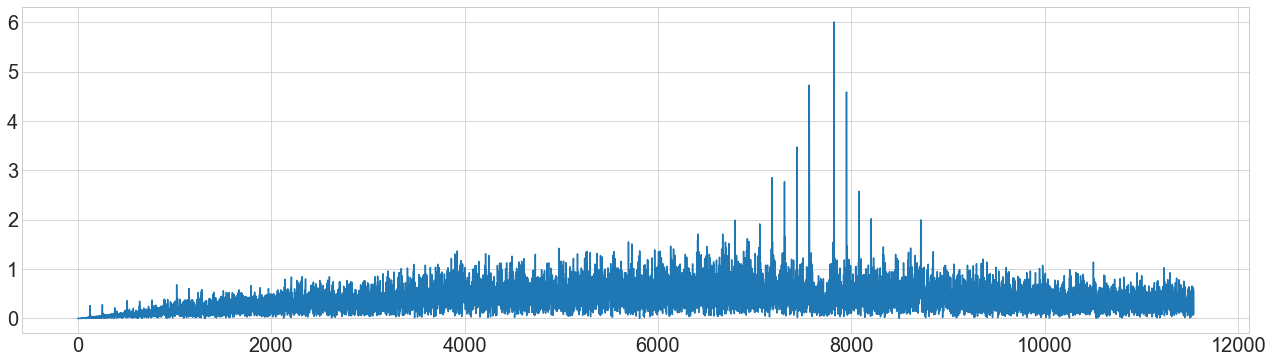

In [341]:
X = np.fft.fft(df_data['Temperature_shifted_week'])
plt.plot(abs(X)[:int(len(X)/2)])
# plt.set_ylim([0, 10])

In [342]:
for i in range(int(len(X)/2)):
    if abs(X[i]) > 3:
        print((i+1)/180)

41.31666666666667
42.022222222222226
42.02777777777778
42.03333333333333
43.455555555555556
44.166666666666664
